In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import timm
import segmentation_models_pytorch as smp
import random
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
batch_size=24
image_count=50
img_size=224
tf = ToTensor()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [2]:
train_df = pd.read_csv(
    '../../data/segmentationDDH/train_aug_segmentation_dataset.csv')
val_df = pd.read_csv(
    '../../data/segmentationDDH/val_aug_segmentation_dataset.csv')

train_img_list = train_df['file name'].to_list()
train_label_list = train_df['standard mask'].to_list()
train_case_list = train_df['case'].to_list()
train_img_path = '../../data/segmentationDDH/aug_dataset/train/'
val_img_list = val_df['file name'].to_list()
val_label_list = val_df['standard mask'].to_list()
val_case_list = val_df['case'].to_list()
val_img_path = '../../data/segmentationDDH/aug_dataset/val/'

val_image=torch.zeros((len(val_img_list),3,img_size,img_size))
val_mask=torch.zeros((len(val_img_list),3,img_size,img_size),dtype=torch.uint8)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),3,img_size,img_size),dtype=torch.uint8)

for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(np.array(Image.open(
        train_img_path+str(train_case_list[i])+'/image/'+train_img_list[i]).resize((img_size, img_size))))
    train_mask[i,1]=tf(np.array(Image.open(
        train_img_path+str(train_case_list[i])+'/mask/'+str(train_label_list[i]).zfill(5)+'/1'+train_img_list[i][train_img_list[i].find('_'):]).resize((img_size, img_size))))
    train_mask[i,2]=tf(np.array(Image.open(
        train_img_path+str(train_case_list[i])+'/mask/'+str(train_label_list[i]).zfill(5)+'/2'+train_img_list[i][train_img_list[i].find('_'):]).resize((img_size, img_size))))
    train_mask[i,0]=torch.where((train_mask[i,1]+train_mask[i,2])==0,1,0)
    

for i in tqdm(range(len(val_img_list))):
    val_image[i] = tf(np.array(Image.open(
        val_img_path+str(val_case_list[i])+'/image/'+val_img_list[i]).resize((img_size, img_size))))
    val_mask[i,1]=tf(np.array(Image.open(
        val_img_path+str(val_case_list[i])+'/mask/'+str(val_label_list[i]).zfill(5)+'/1.png').resize((img_size, img_size))))
    val_mask[i,2]=tf(np.array(Image.open(
        val_img_path+str(val_case_list[i])+'/mask/'+str(val_label_list[i]).zfill(5)+'/2.png').resize((img_size, img_size))))
    val_mask[i,0]=torch.where((val_mask[i,1]+val_mask[i,2])==0,1,0)



  1%|          | 178/20364 [00:42<14:03:56,  2.51s/it]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path = self.img_path[idx]
        label_path =  self.label[idx]
        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

val_dataset = CustomDataset(val_image, val_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
model=smp.DeepLabV3Plus('mobilenet_v2', in_channels=3, classes=3).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=3):
    smooth = 1.
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    
    for class_id in range(num_classes):
        pred_class = pred[:, class_id, ...]
        target_class = target[:, class_id, ...]

        intersection = torch.sum(pred_class * target_class)
        A_sum = torch.sum(pred_class * pred_class)
        B_sum = torch.sum(target_class * target_class)

        dice_per_class[class_id] = 1 - (2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return dice_per_class



NameError: name 'smp' is not defined

epoch: 1/300 Step: 849 dice_loss : 0.2745 dice_score: 0.7255: 100%|██████████| 848/848 [01:16<00:00, 11.11it/s]
Validation epoch: 1/300 Step: 20 dice_loss : 0.1670  dice_score: 0.8330: 100%|██████████| 19/19 [00:00<00:00, 28.85it/s]
epoch: 2/300 Step: 849 dice_loss : 0.1100 dice_score: 0.8900: 100%|██████████| 848/848 [01:14<00:00, 11.36it/s]
Validation epoch: 2/300 Step: 20 dice_loss : 0.1612  dice_score: 0.8388: 100%|██████████| 19/19 [00:00<00:00, 31.28it/s]
epoch: 3/300 Step: 849 dice_loss : 0.0947 dice_score: 0.9053: 100%|██████████| 848/848 [01:13<00:00, 11.62it/s]
Validation epoch: 3/300 Step: 20 dice_loss : 0.1588  dice_score: 0.8412: 100%|██████████| 19/19 [00:00<00:00, 29.79it/s]
epoch: 4/300 Step: 849 dice_loss : 0.0872 dice_score: 0.9128: 100%|██████████| 848/848 [01:11<00:00, 11.83it/s]
Validation epoch: 4/300 Step: 20 dice_loss : 0.1641  dice_score: 0.8359: 100%|██████████| 19/19 [00:00<00:00, 32.51it/s]
epoch: 5/300 Step: 849 dice_loss : 0.0822 dice_score: 0.9178: 100%|█

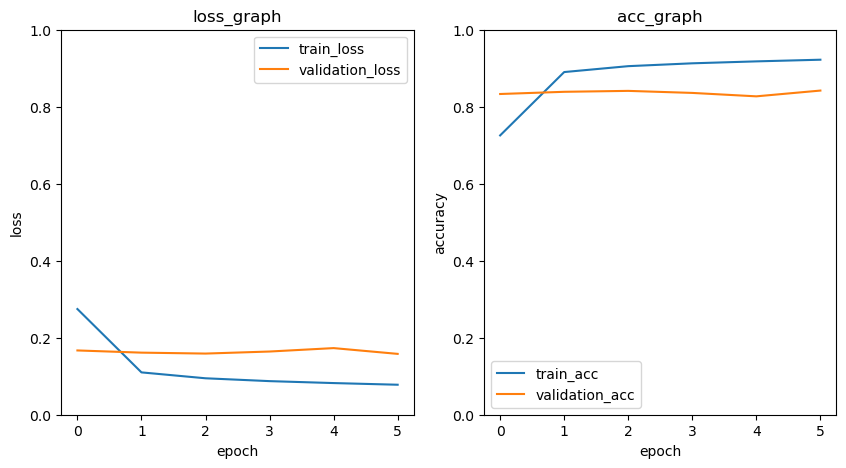

epoch: 7/300 Step: 849 dice_loss : 0.0752 dice_score: 0.9248: 100%|██████████| 848/848 [01:11<00:00, 11.80it/s]
Validation epoch: 7/300 Step: 20 dice_loss : 0.1625  dice_score: 0.8375: 100%|██████████| 19/19 [00:00<00:00, 29.66it/s]
epoch: 8/300 Step: 849 dice_loss : 0.0723 dice_score: 0.9277: 100%|██████████| 848/848 [01:11<00:00, 11.83it/s]
Validation epoch: 8/300 Step: 20 dice_loss : 0.1563  dice_score: 0.8437: 100%|██████████| 19/19 [00:00<00:00, 31.09it/s]
epoch: 9/300 Step: 849 dice_loss : 0.0691 dice_score: 0.9309: 100%|██████████| 848/848 [01:11<00:00, 11.89it/s]
Validation epoch: 9/300 Step: 20 dice_loss : 0.1575  dice_score: 0.8425: 100%|██████████| 19/19 [00:00<00:00, 31.98it/s]
epoch: 10/300 Step: 849 dice_loss : 0.0674 dice_score: 0.9326: 100%|██████████| 848/848 [01:11<00:00, 11.83it/s]
Validation epoch: 10/300 Step: 20 dice_loss : 0.1596  dice_score: 0.8404: 100%|██████████| 19/19 [00:00<00:00, 31.22it/s]
epoch: 11/300 Step: 849 dice_loss : 0.0655 dice_score: 0.9345: 100

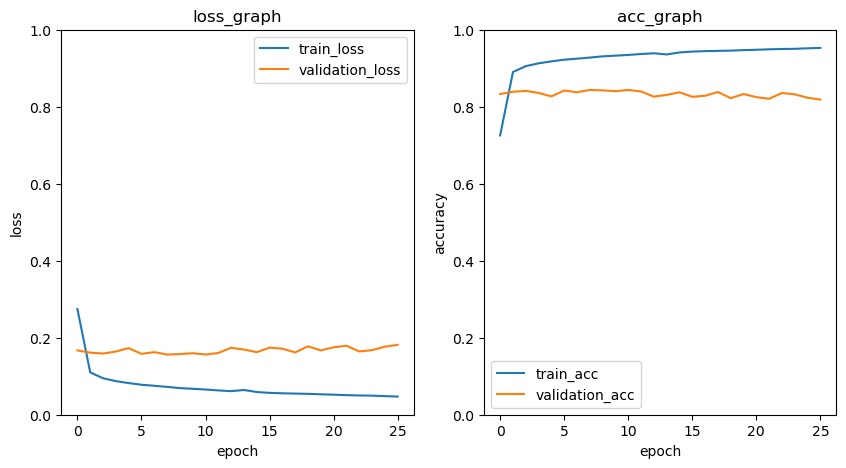

epoch: 27/300 Step: 849 dice_loss : 0.0465 dice_score: 0.9535: 100%|██████████| 848/848 [01:11<00:00, 11.86it/s]
Validation epoch: 27/300 Step: 20 dice_loss : 0.1806  dice_score: 0.8194: 100%|██████████| 19/19 [00:00<00:00, 31.63it/s]
epoch: 28/300 Step: 849 dice_loss : 0.0458 dice_score: 0.9542: 100%|██████████| 848/848 [01:11<00:00, 11.93it/s]
Validation epoch: 28/300 Step: 20 dice_loss : 0.1823  dice_score: 0.8177: 100%|██████████| 19/19 [00:00<00:00, 31.00it/s]
epoch: 29/300 Step: 849 dice_loss : 0.0449 dice_score: 0.9551: 100%|██████████| 848/848 [01:11<00:00, 11.87it/s]
Validation epoch: 29/300 Step: 20 dice_loss : 0.1811  dice_score: 0.8189: 100%|██████████| 19/19 [00:00<00:00, 31.94it/s]
epoch: 30/300 Step: 849 dice_loss : 0.0445 dice_score: 0.9555: 100%|██████████| 848/848 [01:11<00:00, 11.80it/s]
Validation epoch: 30/300 Step: 20 dice_loss : 0.1642  dice_score: 0.8358: 100%|██████████| 19/19 [00:00<00:00, 30.02it/s]
epoch: 31/300 Step: 849 dice_loss : 0.0441 dice_score: 0.955

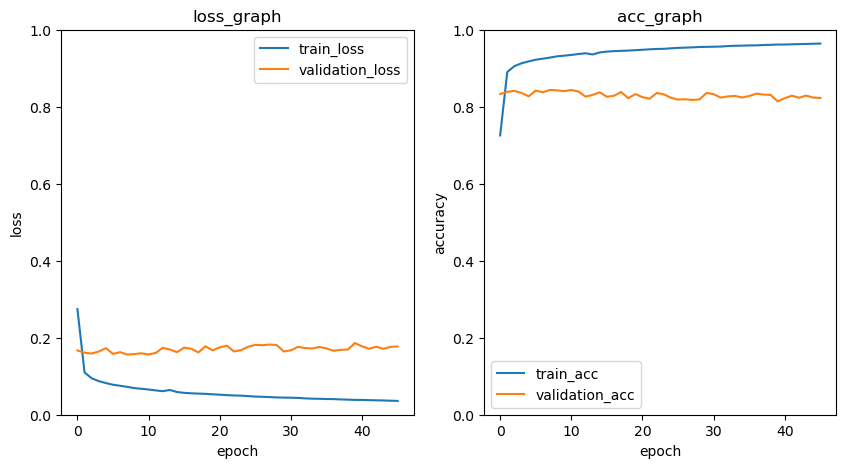

epoch: 47/300 Step: 849 dice_loss : 0.0355 dice_score: 0.9645: 100%|██████████| 848/848 [01:11<00:00, 11.82it/s]
Validation epoch: 47/300 Step: 20 dice_loss : 0.1792  dice_score: 0.8208: 100%|██████████| 19/19 [00:00<00:00, 30.57it/s]
epoch: 48/300 Step: 849 dice_loss : 0.0356 dice_score: 0.9644: 100%|██████████| 848/848 [01:11<00:00, 11.86it/s]
Validation epoch: 48/300 Step: 20 dice_loss : 0.1739  dice_score: 0.8261: 100%|██████████| 19/19 [00:00<00:00, 30.41it/s]
epoch: 49/300 Step: 849 dice_loss : 0.0350 dice_score: 0.9650: 100%|██████████| 848/848 [01:12<00:00, 11.73it/s]
Validation epoch: 49/300 Step: 20 dice_loss : 0.1754  dice_score: 0.8246: 100%|██████████| 19/19 [00:00<00:00, 29.33it/s]
epoch: 50/300 Step: 849 dice_loss : 0.0342 dice_score: 0.9658: 100%|██████████| 848/848 [01:11<00:00, 11.85it/s]
Validation epoch: 50/300 Step: 20 dice_loss : 0.1804  dice_score: 0.8196: 100%|██████████| 19/19 [00:00<00:00, 29.75it/s]
epoch: 51/300 Step: 849 dice_loss : 0.0447 dice_score: 0.955

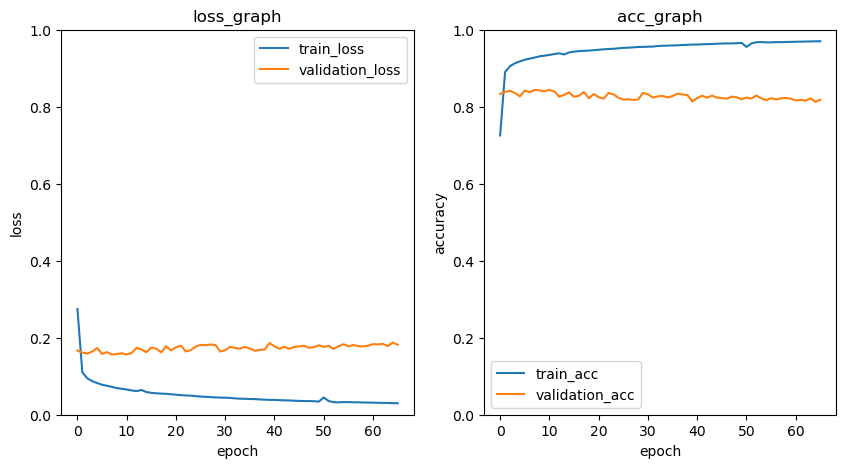

epoch: 67/300 Step: 849 dice_loss : 0.0294 dice_score: 0.9706: 100%|██████████| 848/848 [01:11<00:00, 11.85it/s]
Validation epoch: 67/300 Step: 20 dice_loss : 0.1786  dice_score: 0.8214: 100%|██████████| 19/19 [00:00<00:00, 30.62it/s]
epoch: 68/300 Step: 849 dice_loss : 0.0293 dice_score: 0.9707: 100%|██████████| 848/848 [01:11<00:00, 11.93it/s]
Validation epoch: 68/300 Step: 20 dice_loss : 0.1799  dice_score: 0.8201: 100%|██████████| 19/19 [00:00<00:00, 31.06it/s]
epoch: 69/300 Step: 849 dice_loss : 0.0290 dice_score: 0.9710: 100%|██████████| 848/848 [01:11<00:00, 11.84it/s]
Validation epoch: 69/300 Step: 20 dice_loss : 0.1813  dice_score: 0.8187: 100%|██████████| 19/19 [00:00<00:00, 30.32it/s]
epoch: 70/300 Step: 849 dice_loss : 0.0293 dice_score: 0.9707: 100%|██████████| 848/848 [01:11<00:00, 11.90it/s]
Validation epoch: 70/300 Step: 20 dice_loss : 0.1773  dice_score: 0.8227: 100%|██████████| 19/19 [00:00<00:00, 29.85it/s]
epoch: 71/300 Step: 849 dice_loss : 0.0285 dice_score: 0.971

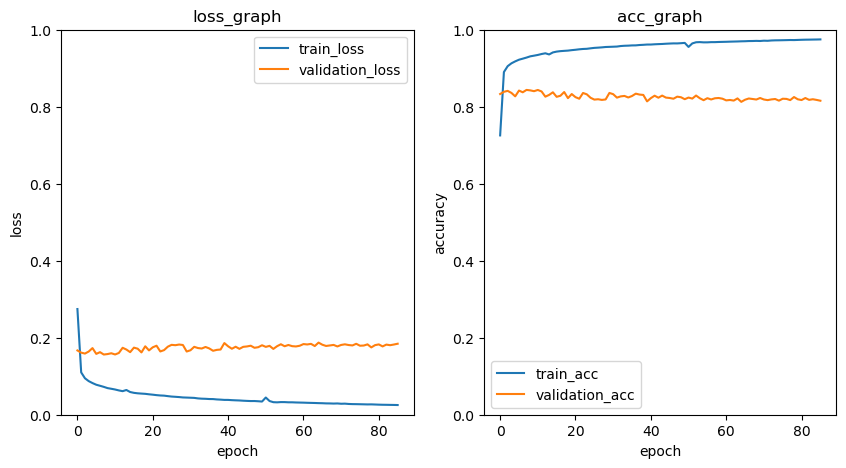

epoch: 87/300 Step: 849 dice_loss : 0.0249 dice_score: 0.9751: 100%|██████████| 848/848 [01:11<00:00, 11.88it/s]
Validation epoch: 87/300 Step: 20 dice_loss : 0.1768  dice_score: 0.8232: 100%|██████████| 19/19 [00:00<00:00, 30.12it/s]
epoch: 88/300 Step: 849 dice_loss : 0.0247 dice_score: 0.9753: 100%|██████████| 848/848 [01:11<00:00, 11.90it/s]
Validation epoch: 88/300 Step: 20 dice_loss : 0.1839  dice_score: 0.8161: 100%|██████████| 19/19 [00:00<00:00, 29.57it/s]
epoch: 89/300 Step: 849 dice_loss : 0.0246 dice_score: 0.9754: 100%|██████████| 848/848 [01:11<00:00, 11.84it/s]
Validation epoch: 89/300 Step: 20 dice_loss : 0.1860  dice_score: 0.8140: 100%|██████████| 19/19 [00:00<00:00, 30.23it/s]
epoch: 90/300 Step: 849 dice_loss : 0.0245 dice_score: 0.9755: 100%|██████████| 848/848 [01:11<00:00, 11.86it/s]
Validation epoch: 90/300 Step: 20 dice_loss : 0.1776  dice_score: 0.8224: 100%|██████████| 19/19 [00:00<00:00, 29.18it/s]
epoch: 91/300 Step: 849 dice_loss : 0.0241 dice_score: 0.975

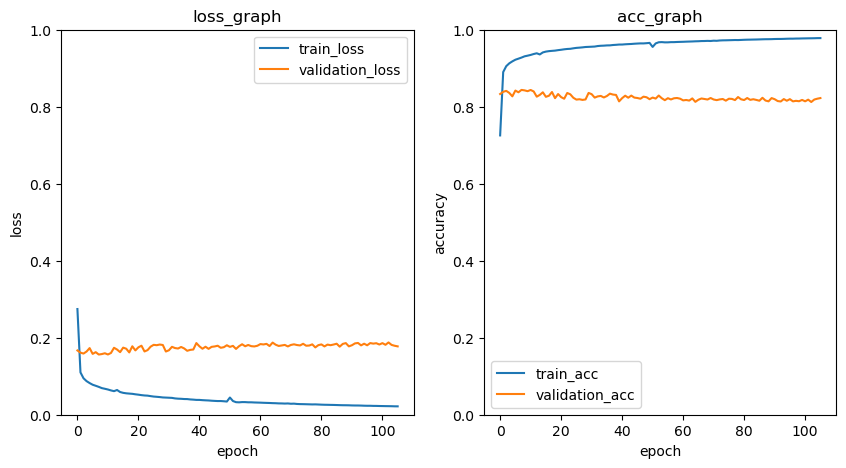

epoch: 107/300 Step: 849 dice_loss : 0.0217 dice_score: 0.9783: 100%|██████████| 848/848 [01:11<00:00, 11.85it/s]
Validation epoch: 107/300 Step: 20 dice_loss : 0.1799  dice_score: 0.8201: 100%|██████████| 19/19 [00:00<00:00, 27.70it/s]
epoch: 108/300 Step: 849 dice_loss : 0.0215 dice_score: 0.9785: 100%|██████████| 848/848 [01:11<00:00, 11.91it/s]
Validation epoch: 108/300 Step: 20 dice_loss : 0.1834  dice_score: 0.8166: 100%|██████████| 19/19 [00:00<00:00, 27.84it/s]
epoch: 109/300 Step: 849 dice_loss : 0.0214 dice_score: 0.9786: 100%|██████████| 848/848 [01:11<00:00, 11.90it/s]
Validation epoch: 109/300 Step: 20 dice_loss : 0.1846  dice_score: 0.8154: 100%|██████████| 19/19 [00:00<00:00, 30.23it/s]
epoch: 110/300 Step: 849 dice_loss : 0.0213 dice_score: 0.9787: 100%|██████████| 848/848 [01:11<00:00, 11.89it/s]
Validation epoch: 110/300 Step: 20 dice_loss : 0.1843  dice_score: 0.8157: 100%|██████████| 19/19 [00:00<00:00, 29.83it/s]
epoch: 111/300 Step: 849 dice_loss : 0.0211 dice_sco

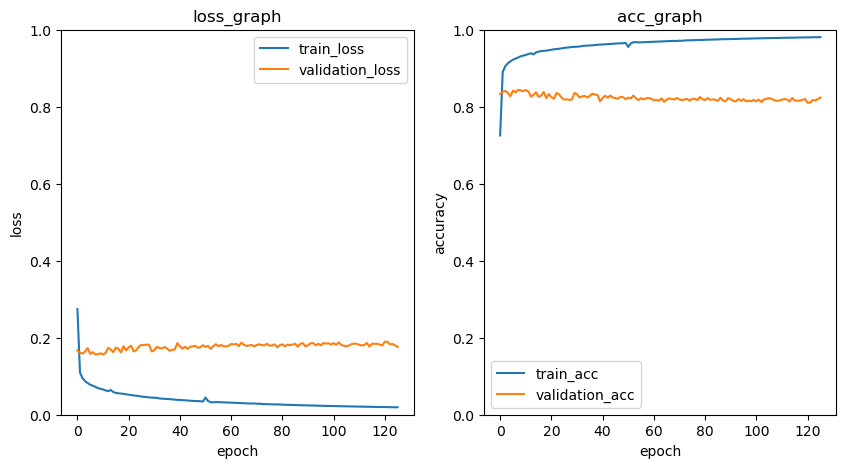

epoch: 127/300 Step: 849 dice_loss : 0.0192 dice_score: 0.9808: 100%|██████████| 848/848 [01:11<00:00, 11.91it/s]
Validation epoch: 127/300 Step: 20 dice_loss : 0.1826  dice_score: 0.8174: 100%|██████████| 19/19 [00:00<00:00, 31.03it/s]
epoch: 128/300 Step: 849 dice_loss : 0.0190 dice_score: 0.9810: 100%|██████████| 848/848 [01:11<00:00, 11.88it/s]
Validation epoch: 128/300 Step: 20 dice_loss : 0.1863  dice_score: 0.8137: 100%|██████████| 19/19 [00:00<00:00, 31.29it/s]
epoch: 129/300 Step: 849 dice_loss : 0.0190 dice_score: 0.9810: 100%|██████████| 848/848 [01:11<00:00, 11.93it/s]
Validation epoch: 129/300 Step: 20 dice_loss : 0.1836  dice_score: 0.8164: 100%|██████████| 19/19 [00:00<00:00, 28.74it/s]
epoch: 130/300 Step: 849 dice_loss : 0.0188 dice_score: 0.9812: 100%|██████████| 848/848 [01:11<00:00, 11.90it/s]
Validation epoch: 130/300 Step: 20 dice_loss : 0.1804  dice_score: 0.8196: 100%|██████████| 19/19 [00:00<00:00, 30.83it/s]
epoch: 131/300 Step: 849 dice_loss : 0.0188 dice_sco

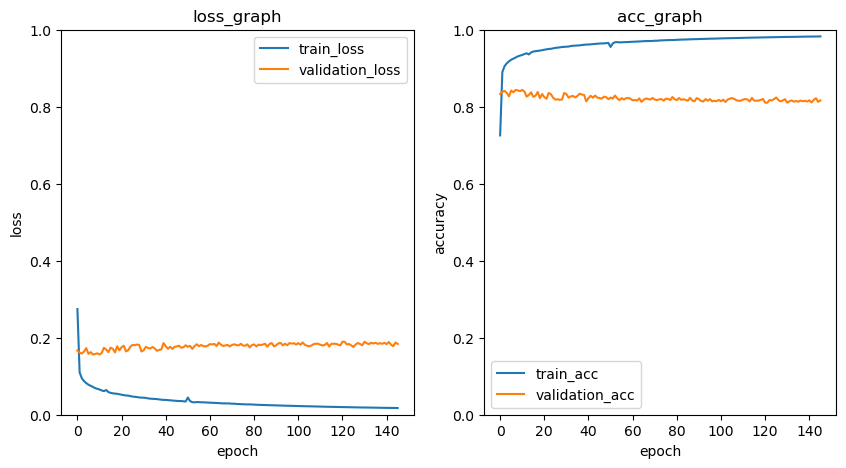

epoch: 147/300 Step: 849 dice_loss : 0.0173 dice_score: 0.9827: 100%|██████████| 848/848 [01:11<00:00, 11.91it/s]
Validation epoch: 147/300 Step: 20 dice_loss : 0.1845  dice_score: 0.8155: 100%|██████████| 19/19 [00:00<00:00, 30.21it/s]
epoch: 148/300 Step: 849 dice_loss : 0.0172 dice_score: 0.9828: 100%|██████████| 848/848 [01:10<00:00, 11.95it/s]
Validation epoch: 148/300 Step: 20 dice_loss : 0.1843  dice_score: 0.8157: 100%|██████████| 19/19 [00:00<00:00, 29.80it/s]
epoch: 149/300 Step: 849 dice_loss : 0.0172 dice_score: 0.9828: 100%|██████████| 848/848 [01:11<00:00, 11.93it/s]
Validation epoch: 149/300 Step: 20 dice_loss : 0.1824  dice_score: 0.8176: 100%|██████████| 19/19 [00:00<00:00, 31.20it/s]
epoch: 150/300 Step: 849 dice_loss : 0.0171 dice_score: 0.9829: 100%|██████████| 848/848 [01:11<00:00, 11.91it/s]
Validation epoch: 150/300 Step: 20 dice_loss : 0.1875  dice_score: 0.8125: 100%|██████████| 19/19 [00:00<00:00, 30.58it/s]
epoch: 151/300 Step: 849 dice_loss : 0.0170 dice_sco

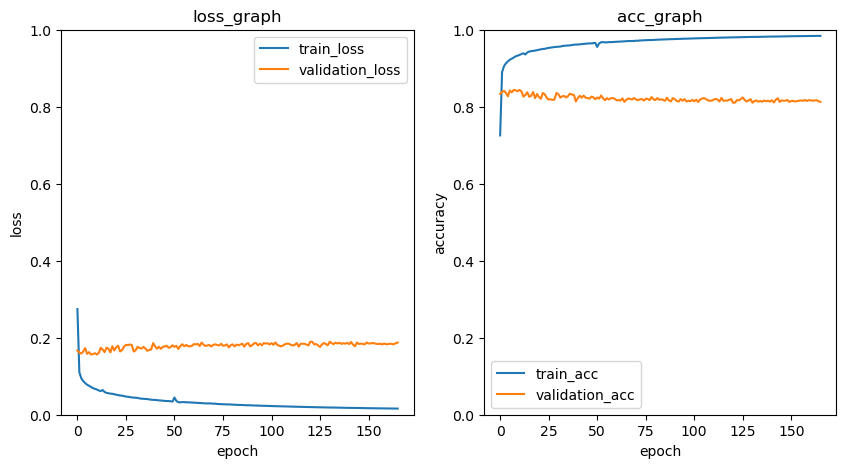

epoch: 167/300 Step: 849 dice_loss : 0.0160 dice_score: 0.9840: 100%|██████████| 848/848 [01:11<00:00, 11.91it/s]
Validation epoch: 167/300 Step: 20 dice_loss : 0.1865  dice_score: 0.8135: 100%|██████████| 19/19 [00:00<00:00, 31.28it/s]
epoch: 168/300 Step: 849 dice_loss : 0.0158 dice_score: 0.9842: 100%|██████████| 848/848 [01:11<00:00, 11.88it/s]
Validation epoch: 168/300 Step: 20 dice_loss : 0.1873  dice_score: 0.8127: 100%|██████████| 19/19 [00:00<00:00, 28.40it/s]
epoch: 169/300 Step: 849 dice_loss : 0.0156 dice_score: 0.9844: 100%|██████████| 848/848 [01:11<00:00, 11.87it/s]
Validation epoch: 169/300 Step: 20 dice_loss : 0.1842  dice_score: 0.8158: 100%|██████████| 19/19 [00:00<00:00, 28.80it/s]
epoch: 170/300 Step: 849 dice_loss : 0.0155 dice_score: 0.9845: 100%|██████████| 848/848 [01:12<00:00, 11.71it/s]
Validation epoch: 170/300 Step: 20 dice_loss : 0.1817  dice_score: 0.8183: 100%|██████████| 19/19 [00:00<00:00, 29.92it/s]
epoch: 171/300 Step: 849 dice_loss : 0.0155 dice_sco

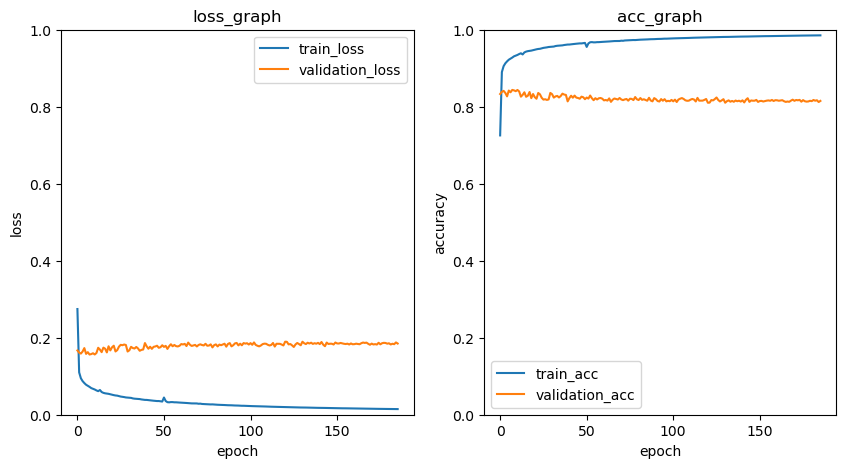

epoch: 187/300 Step: 849 dice_loss : 0.0145 dice_score: 0.9855: 100%|██████████| 848/848 [01:11<00:00, 11.93it/s]
Validation epoch: 187/300 Step: 20 dice_loss : 0.1854  dice_score: 0.8146: 100%|██████████| 19/19 [00:00<00:00, 32.08it/s]
epoch: 188/300 Step: 849 dice_loss : 0.0145 dice_score: 0.9855: 100%|██████████| 848/848 [01:11<00:00, 11.90it/s]
Validation epoch: 188/300 Step: 20 dice_loss : 0.1808  dice_score: 0.8192: 100%|██████████| 19/19 [00:00<00:00, 31.44it/s]
epoch: 189/300 Step: 849 dice_loss : 0.0145 dice_score: 0.9855: 100%|██████████| 848/848 [01:11<00:00, 11.93it/s]
Validation epoch: 189/300 Step: 20 dice_loss : 0.1841  dice_score: 0.8159: 100%|██████████| 19/19 [00:00<00:00, 30.48it/s]
epoch: 190/300 Step: 849 dice_loss : 0.0144 dice_score: 0.9856: 100%|██████████| 848/848 [01:10<00:00, 11.98it/s]
Validation epoch: 190/300 Step: 20 dice_loss : 0.1868  dice_score: 0.8132: 100%|██████████| 19/19 [00:00<00:00, 29.33it/s]
epoch: 191/300 Step: 849 dice_loss : 0.0143 dice_sco

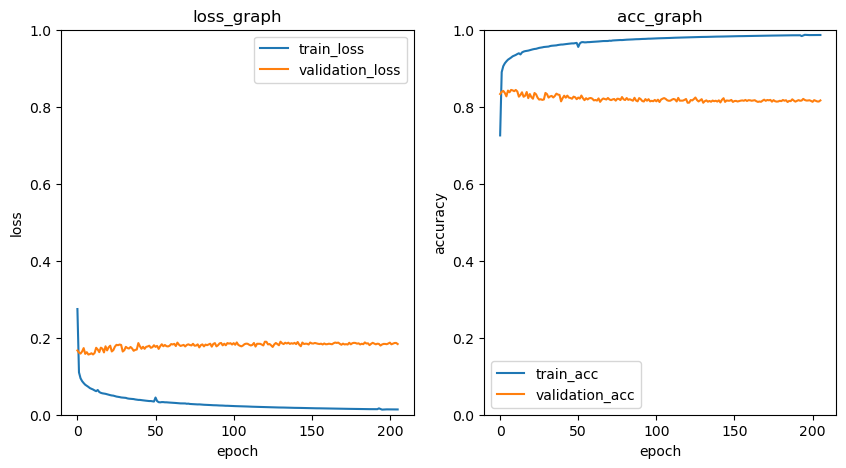

epoch: 207/300 Step: 849 dice_loss : 0.0137 dice_score: 0.9863: 100%|██████████| 848/848 [01:10<00:00, 11.97it/s]
Validation epoch: 207/300 Step: 20 dice_loss : 0.1823  dice_score: 0.8177: 100%|██████████| 19/19 [00:00<00:00, 30.50it/s]
epoch: 208/300 Step: 849 dice_loss : 0.0136 dice_score: 0.9864: 100%|██████████| 848/848 [01:10<00:00, 11.97it/s]
Validation epoch: 208/300 Step: 20 dice_loss : 0.1850  dice_score: 0.8150: 100%|██████████| 19/19 [00:00<00:00, 30.81it/s]
epoch: 209/300 Step: 849 dice_loss : 0.0135 dice_score: 0.9865: 100%|██████████| 848/848 [01:10<00:00, 11.97it/s]
Validation epoch: 209/300 Step: 20 dice_loss : 0.1801  dice_score: 0.8199: 100%|██████████| 19/19 [00:00<00:00, 31.73it/s]
epoch: 210/300 Step: 849 dice_loss : 0.0135 dice_score: 0.9865: 100%|██████████| 848/848 [01:10<00:00, 12.01it/s]
Validation epoch: 210/300 Step: 20 dice_loss : 0.1874  dice_score: 0.8126: 100%|██████████| 19/19 [00:00<00:00, 29.70it/s]
epoch: 211/300 Step: 849 dice_loss : 0.0135 dice_sco

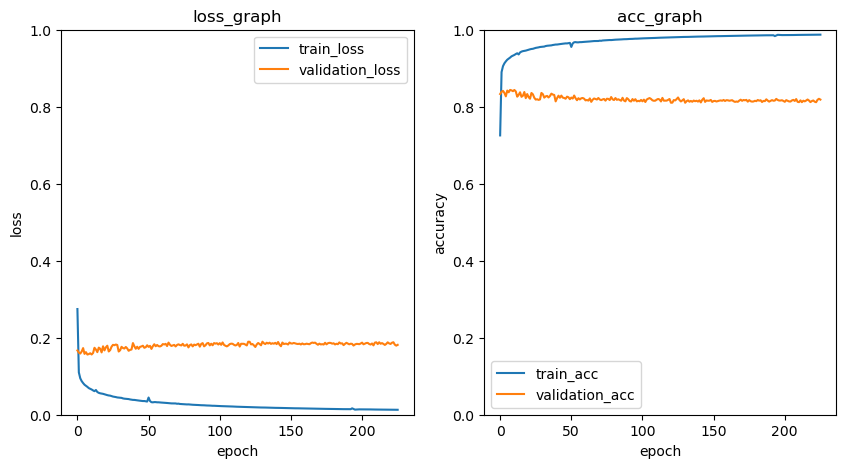

epoch: 227/300 Step: 849 dice_loss : 0.0128 dice_score: 0.9872: 100%|██████████| 848/848 [01:10<00:00, 12.01it/s]
Validation epoch: 227/300 Step: 20 dice_loss : 0.1845  dice_score: 0.8155: 100%|██████████| 19/19 [00:00<00:00, 32.13it/s]
epoch: 228/300 Step: 849 dice_loss : 0.0127 dice_score: 0.9873: 100%|██████████| 848/848 [01:10<00:00, 12.02it/s]
Validation epoch: 228/300 Step: 20 dice_loss : 0.1841  dice_score: 0.8159: 100%|██████████| 19/19 [00:00<00:00, 30.90it/s]
epoch: 229/300 Step: 849 dice_loss : 0.0127 dice_score: 0.9873: 100%|██████████| 848/848 [01:10<00:00, 11.99it/s]
Validation epoch: 229/300 Step: 20 dice_loss : 0.1825  dice_score: 0.8175: 100%|██████████| 19/19 [00:00<00:00, 32.29it/s]
epoch: 230/300 Step: 849 dice_loss : 0.0128 dice_score: 0.9872: 100%|██████████| 848/848 [01:10<00:00, 11.98it/s]
Validation epoch: 230/300 Step: 20 dice_loss : 0.1822  dice_score: 0.8178: 100%|██████████| 19/19 [00:00<00:00, 32.86it/s]
epoch: 231/300 Step: 849 dice_loss : 0.0126 dice_sco

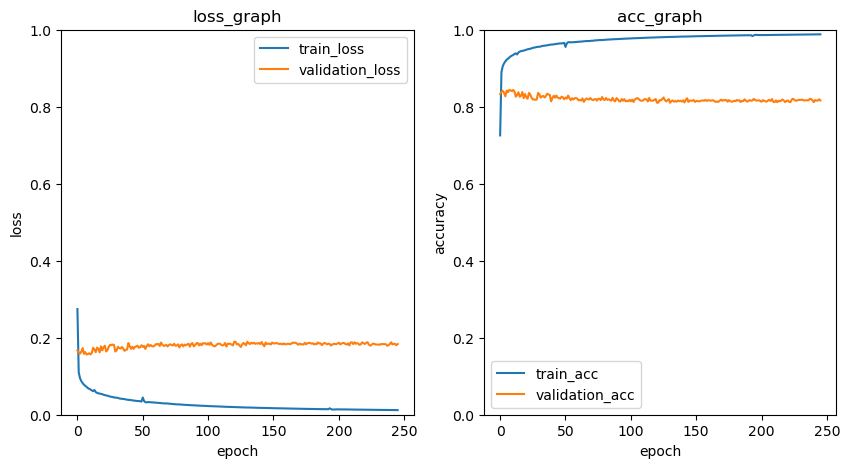

epoch: 247/300 Step: 849 dice_loss : 0.0119 dice_score: 0.9881: 100%|██████████| 848/848 [01:10<00:00, 12.01it/s]
Validation epoch: 247/300 Step: 20 dice_loss : 0.1861  dice_score: 0.8139: 100%|██████████| 19/19 [00:00<00:00, 30.08it/s]
epoch: 248/300 Step: 849 dice_loss : 0.0120 dice_score: 0.9880: 100%|██████████| 848/848 [01:10<00:00, 11.97it/s]
Validation epoch: 248/300 Step: 20 dice_loss : 0.1853  dice_score: 0.8147: 100%|██████████| 19/19 [00:00<00:00, 31.81it/s]
epoch: 249/300 Step: 849 dice_loss : 0.0119 dice_score: 0.9881: 100%|██████████| 848/848 [01:11<00:00, 11.90it/s]
Validation epoch: 249/300 Step: 20 dice_loss : 0.1852  dice_score: 0.8148: 100%|██████████| 19/19 [00:00<00:00, 32.23it/s]
epoch: 250/300 Step: 849 dice_loss : 0.0119 dice_score: 0.9881: 100%|██████████| 848/848 [01:10<00:00, 12.01it/s]
Validation epoch: 250/300 Step: 20 dice_loss : 0.1862  dice_score: 0.8138: 100%|██████████| 19/19 [00:00<00:00, 32.13it/s]
epoch: 251/300 Step: 849 dice_loss : 0.0119 dice_sco

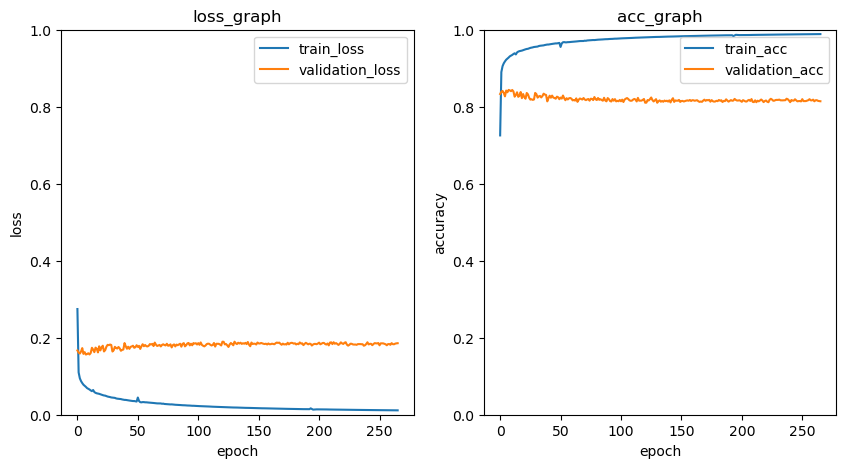

epoch: 267/300 Step: 849 dice_loss : 0.0113 dice_score: 0.9887: 100%|██████████| 848/848 [01:10<00:00, 11.96it/s]
Validation epoch: 267/300 Step: 20 dice_loss : 0.1799  dice_score: 0.8201: 100%|██████████| 19/19 [00:00<00:00, 31.28it/s]
epoch: 268/300 Step: 849 dice_loss : 0.0114 dice_score: 0.9886: 100%|██████████| 848/848 [01:11<00:00, 11.94it/s]
Validation epoch: 268/300 Step: 20 dice_loss : 0.1832  dice_score: 0.8168: 100%|██████████| 19/19 [00:00<00:00, 31.76it/s]
epoch: 269/300 Step: 849 dice_loss : 0.0113 dice_score: 0.9887: 100%|██████████| 848/848 [01:10<00:00, 11.96it/s]
Validation epoch: 269/300 Step: 20 dice_loss : 0.1847  dice_score: 0.8153: 100%|██████████| 19/19 [00:00<00:00, 31.92it/s]
epoch: 270/300 Step: 849 dice_loss : 0.0112 dice_score: 0.9888: 100%|██████████| 848/848 [01:11<00:00, 11.86it/s]
Validation epoch: 270/300 Step: 20 dice_loss : 0.1798  dice_score: 0.8202: 100%|██████████| 19/19 [00:00<00:00, 32.36it/s]
epoch: 271/300 Step: 849 dice_loss : 0.0112 dice_sco

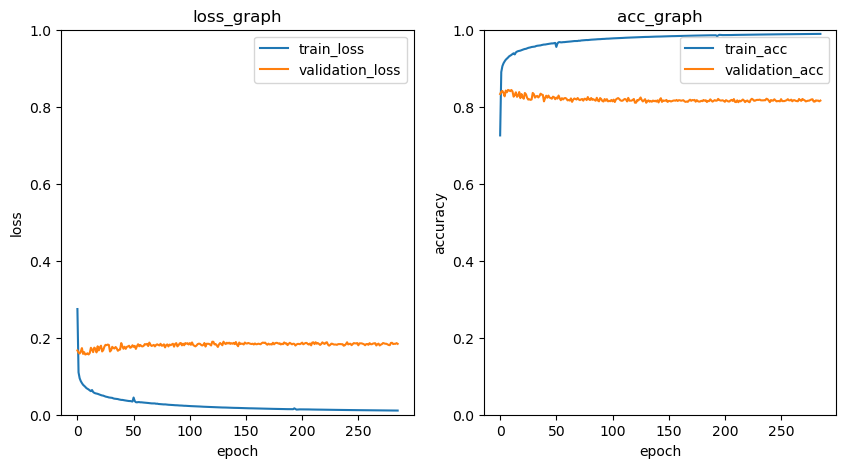

epoch: 287/300 Step: 849 dice_loss : 0.0107 dice_score: 0.9893: 100%|██████████| 848/848 [01:10<00:00, 12.02it/s]
Validation epoch: 287/300 Step: 20 dice_loss : 0.1815  dice_score: 0.8185: 100%|██████████| 19/19 [00:00<00:00, 31.31it/s]
epoch: 288/300 Step: 849 dice_loss : 0.0107 dice_score: 0.9893: 100%|██████████| 848/848 [01:10<00:00, 12.01it/s]
Validation epoch: 288/300 Step: 20 dice_loss : 0.1818  dice_score: 0.8182: 100%|██████████| 19/19 [00:00<00:00, 32.49it/s]
epoch: 289/300 Step: 849 dice_loss : 0.0107 dice_score: 0.9893: 100%|██████████| 848/848 [01:10<00:00, 12.06it/s]
Validation epoch: 289/300 Step: 20 dice_loss : 0.1866  dice_score: 0.8134: 100%|██████████| 19/19 [00:00<00:00, 30.64it/s]
epoch: 290/300 Step: 849 dice_loss : 0.0106 dice_score: 0.9894: 100%|██████████| 848/848 [01:10<00:00, 12.01it/s]
Validation epoch: 290/300 Step: 20 dice_loss : 0.1837  dice_score: 0.8163: 100%|██████████| 19/19 [00:00<00:00, 32.42it/s]
epoch: 291/300 Step: 849 dice_loss : 0.0106 dice_sco

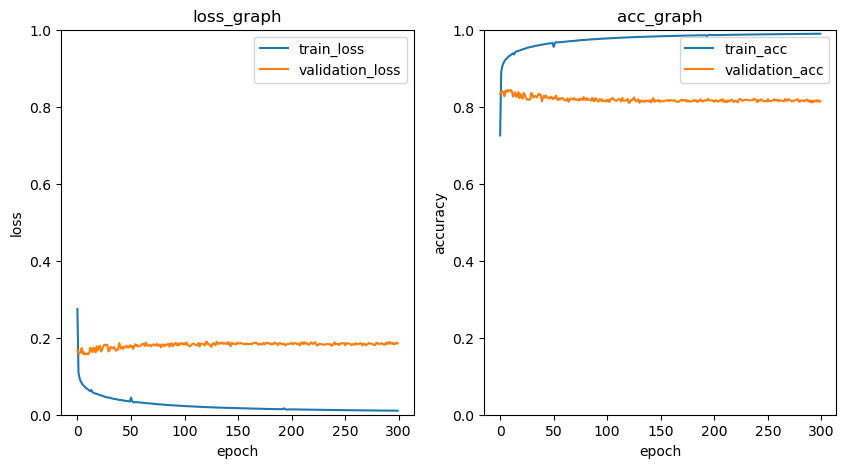

batch size= 4
image size= 224
learning rate= 0.0001


In [ ]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(300):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y,num_classes=3) # cost 구함
        acc=1-dice_loss(predict, y,num_classes=3)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{300} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = calc_loss(predict, y,metrics) # cost 구함
            acc=1-calc_loss(predict, y,metrics)
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"Validation epoch: {epoch+1}/{300} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/segmentation/DeepLabV3Plus_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%20==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 4')
print('image size= 224')
print('learning rate= 0.0001')